# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Graphing Correlations

/Users/ncolina/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/ncolina/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


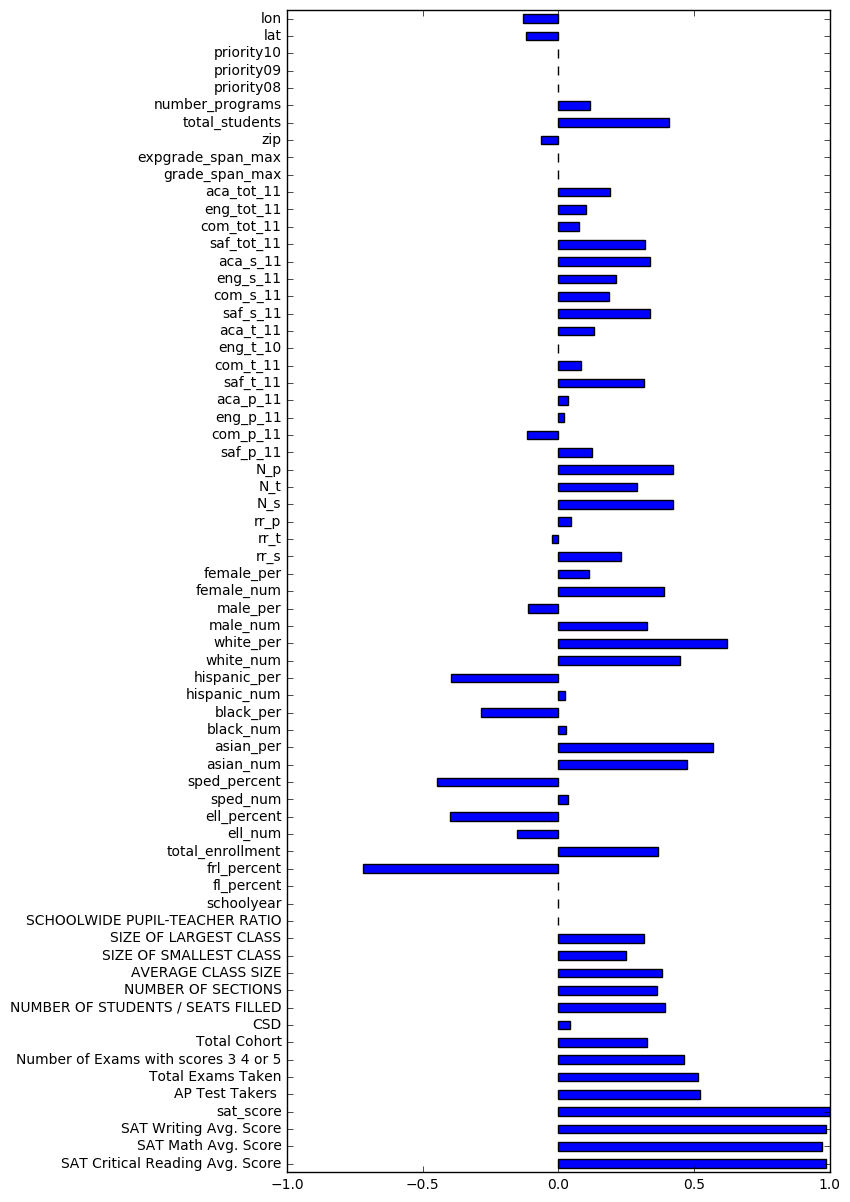

In [10]:
%matplotlib inline
correlations.plot.barh(figsize=(7,15),xlim=(-1,1))


We see a strong negative correlation between sat_scores and the frl_percent.

There are also high levels of correlation between suveys on safety and SAT scores

Correlations also indicate that the schools with higher percent Asian and White on average get higher SAT scores.

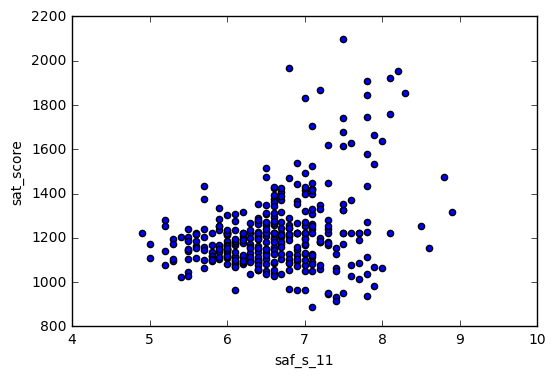

In [11]:
combined.plot.scatter(x='saf_s_11',y='sat_score')

From the graph above you can see that as the safety rating goes up there is a weak correlation to the sat scores. However what is interesting is the cluster in the lower left part of the graph.


# Graphing average district safety rating

In [ ]:
ave_district=combined.groupby('school_dist').agg(numpy.mean)
ave_district["saf_s_11"]
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes=ave_district['lon'].tolist()
latitudes=ave_district['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=ave_district["saf_s_11"], cmap="summer")
plt.colorbar()
plt.show()

Looking at how safety scores are distributed geographically, we see tha there is an are in the middle (Brooklyn) where there schools are perceived as less safe by students. 

# Looking at racial differences on SAT scores

In [ ]:
cols=['white_per','asian_per','black_per','hispanic_per']
correlations[cols].plot.bar()

Positive correlations (Strong) for whites and asians

In [ ]:
cols=['white_per','asian_per','black_per','hispanic_per']
fig=plt.figure(figsize=(7,15))
for i in range(1,5):
    ax=fig.add_subplot(4,1,i)
    ax.scatter(x=combined[cols[i-1]], y=combined['sat_score'])
    ax.set_title(cols[i-1]+' vs. sat_score')

There are no schools with high SAT scores and high percentages of balck and hispanic students

In [ ]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

In [ ]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]['SCHOOL NAME']

Schools that were clasified as international schools or are targeted toward immigrants tended to be mostly hispanic.

Schools with low (< 10%) hispanic populations and high SAT scores were usually ones that focused on technical things or sciences AKA speciallized.  It is important to note that these schools have entrance tests and are the more desireable schools. This could indicate that hispanics are being descriminated against or they are simpling testing low in the entrance tests.

In [ ]:
cols=['male_per','female_per']
correlations[cols].plot.bar()

Correlation data indicates that the higher the male percentage the lower average SAT scores. The opposite holds for women. 

In [ ]:
combined.plot.scatter(x='female_per',y='sat_score')

This scatter plot shows that the correlation may not be that storng and may be just an effect of the cluster in the middle.

In [ ]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]["SCHOOL NAME"]

Research showed that these schools are mostly forcused in the liberal arts and have high levels of academic standards

# Looking at AP test and SAT scores

In [ ]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per',y='sat_score')

There are a cluster of schools with about half taking at least one AP test and scoring high on SAT

In [ ]:
combined[(combined['ap_per']>0.4)&(combined['sat_score']>1700)]["SCHOOL NAME"]